<a href="https://colab.research.google.com/github/Aravindh4404/FYPSeagullClassification01/blob/main/VIT3interpretability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install captum

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-5-d750ef7b7e35>:199: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/My Drive/FYP/VIT3_HQ2_20250206/latest_mode


Processing class: Slaty_Backed_Gull
Processing: /content/drive/My Drive/FYP/Dataset/HQ2/train/Slaty_Backed_Gull/0H5A6787.JPG


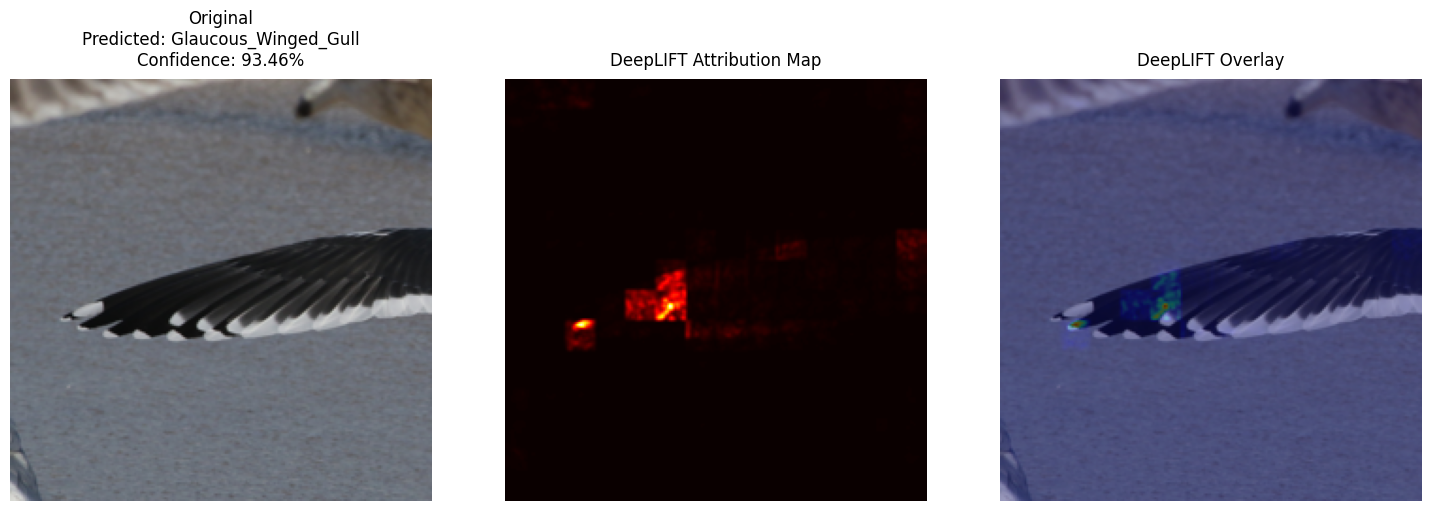

Visualization complete for: 0H5A6787.JPG
Processing: /content/drive/My Drive/FYP/Dataset/HQ2/train/Slaty_Backed_Gull/0H5A8628.JPG


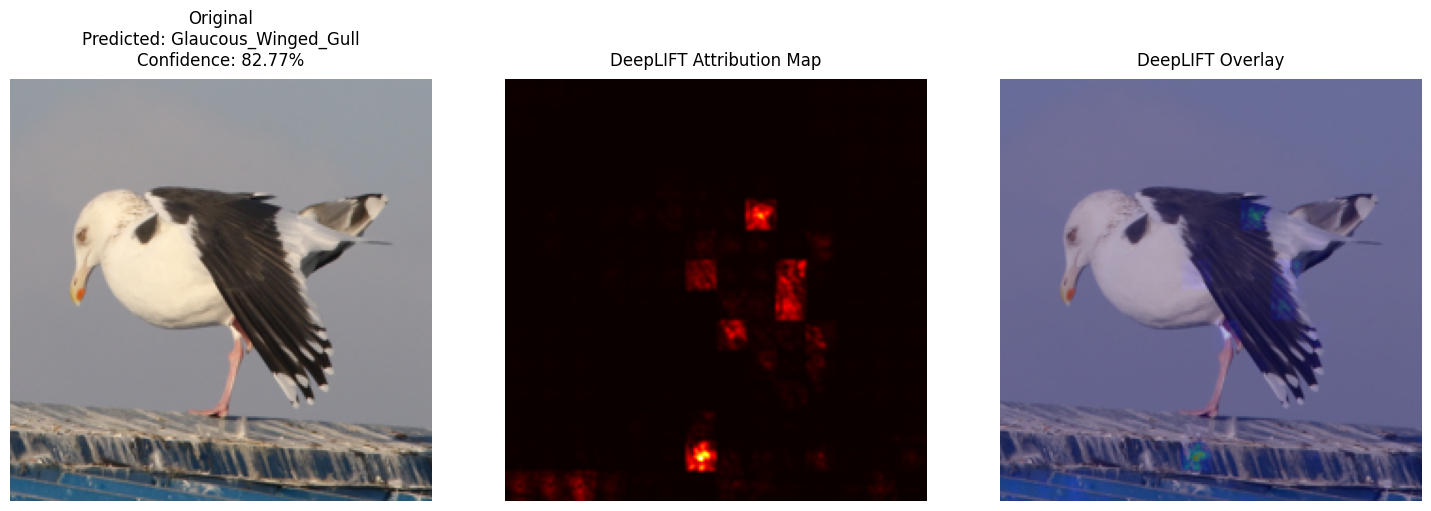

Visualization complete for: 0H5A8628.JPG
Processing: /content/drive/My Drive/FYP/Dataset/HQ2/train/Slaty_Backed_Gull/0H5A7391.JPG


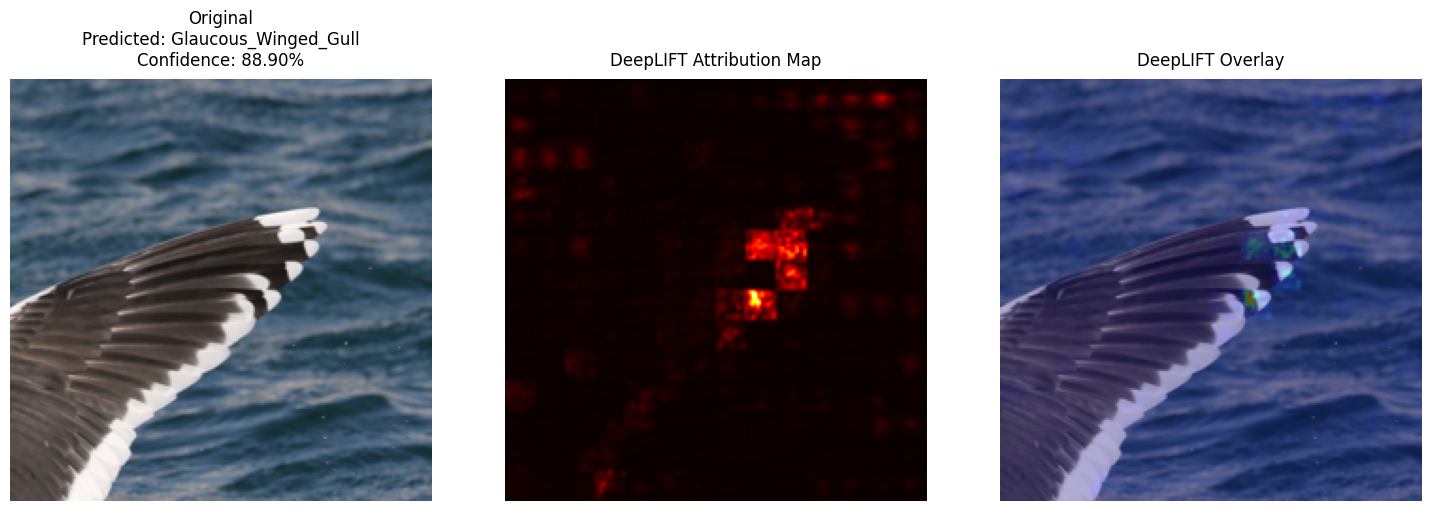

Visualization complete for: 0H5A7391.JPG

Processing class: Glaucous_Winged_Gull
Processing: /content/drive/My Drive/FYP/Dataset/HQ2/train/Glaucous_Winged_Gull/640 (29).jpeg


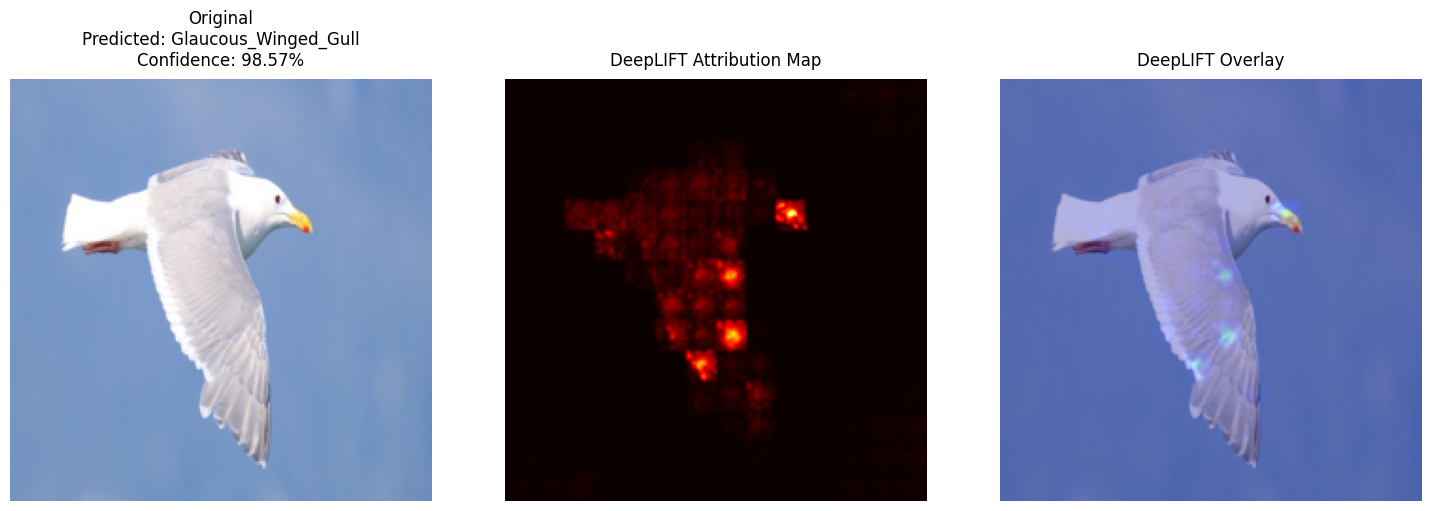

Visualization complete for: 640 (29).jpeg
Processing: /content/drive/My Drive/FYP/Dataset/HQ2/train/Glaucous_Winged_Gull/download (97).jpeg


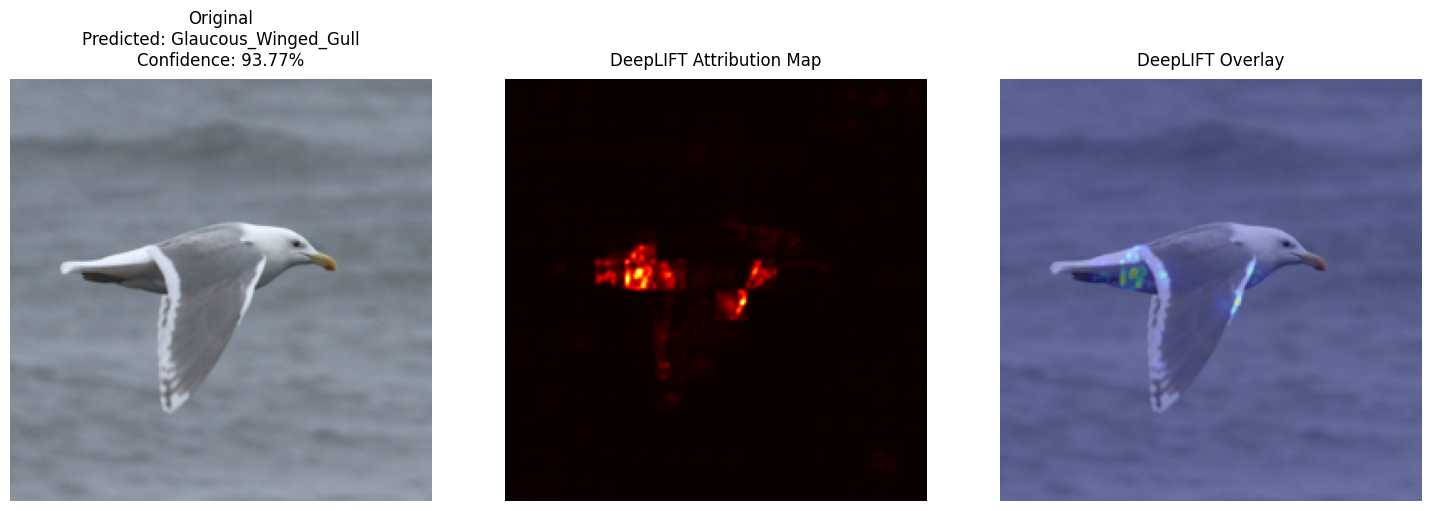

Visualization complete for: download (97).jpeg
Processing: /content/drive/My Drive/FYP/Dataset/HQ2/train/Glaucous_Winged_Gull/image_90.jpg


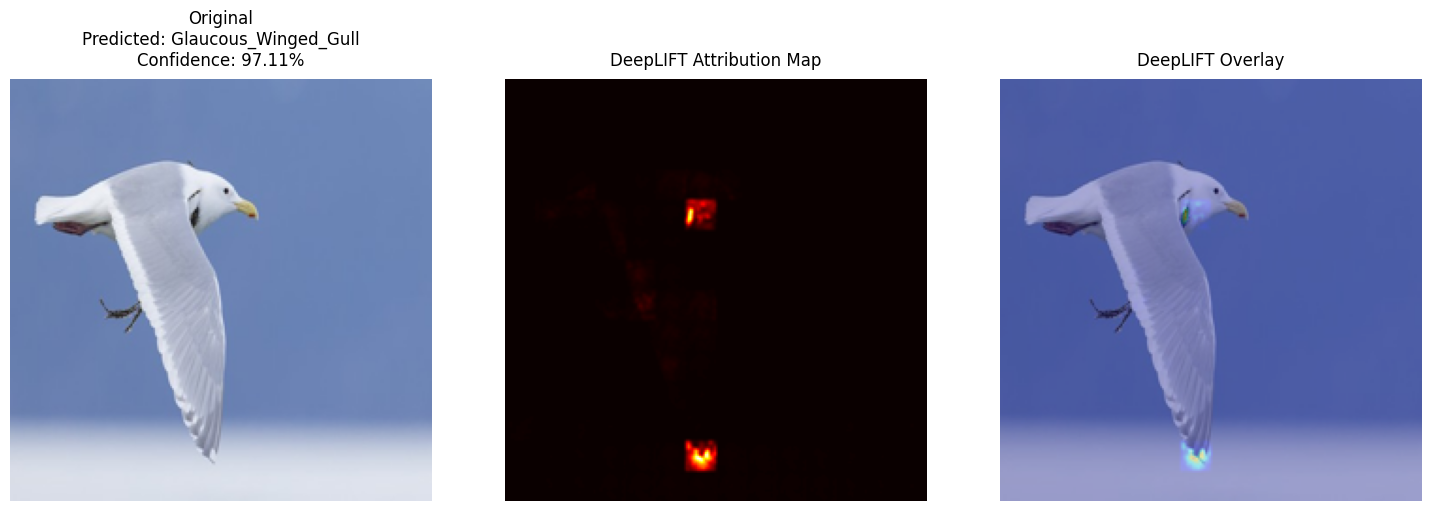

Visualization complete for: image_90.jpg


In [5]:
import torch
import torch.nn as nn
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import timm
import os
from typing import Tuple, Optional
from torchvision import transforms
from captum.attr import DeepLift
from datetime import datetime

# Enhanced ViT Model with Dropout
class ViTEnhanced(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super().__init__()
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=0)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(self.vit.num_features, 2)

    def forward(self, x):
        x = self.vit(x)
        x = self.dropout(x)
        return self.fc(x)


class DeepLIFTAnalyzer:
    def __init__(self, model: nn.Module, class_names: list,
                 save_dir: str = None,
                 device: str = 'cuda' if torch.cuda.is_available() else 'cpu'):
        self.model = model.to(device)
        self.device = device
        self.class_names = class_names
        self.save_dir = save_dir
        if save_dir:
            os.makedirs(save_dir, exist_ok=True)

        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
        ])
        self.deep_lift = DeepLift(self.model)

class DeepLIFTAnalyzer:
    def __init__(self, model: nn.Module, class_names: list,
                 save_dir: str = None,
                 device: str = 'cuda' if torch.cuda.is_available() else 'cpu'):
        self.model = model.to(device)
        self.device = device
        self.class_names = class_names
        self.save_dir = save_dir
        if save_dir:
            os.makedirs(save_dir, exist_ok=True)

        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
        ])
        self.deep_lift = DeepLift(self.model)

    def preprocess_image(self, image_path: str) -> Tuple[torch.Tensor, np.ndarray]:
        """Preprocess image and return both tensor and original image."""
        original_image = Image.open(image_path).convert("RGB")
        original_image = original_image.resize((224, 224))
        original_np = np.array(original_image)

        image_tensor = self.transform(original_image).unsqueeze(0).to(self.device)
        return image_tensor, original_np

    def generate_deeplift_attribution(self, image_tensor: torch.Tensor) -> Tuple[np.ndarray, int, float]:
        """Generate DeepLIFT attribution map with confidence score."""
        self.model.eval()

        baseline = torch.zeros_like(image_tensor).to(self.device)

        with torch.no_grad():
            output = self.model(image_tensor)
            probabilities = torch.nn.functional.softmax(output, dim=1)
            confidence_score = torch.max(probabilities).item()
            pred_class = output.argmax().item()

        try:
            attribution = self.deep_lift.attribute(
                image_tensor,
                baselines=baseline,
                target=pred_class,
                return_convergence_delta=False
            )

            attribution = attribution.detach().cpu().numpy()
            attribution = np.mean(np.abs(attribution), axis=1)
            attribution = attribution.squeeze()
            attribution = cv2.resize(attribution, (224, 224))
            attribution = (attribution - attribution.min()) / (attribution.max() - attribution.min() + 1e-8)
            attribution = cv2.GaussianBlur(attribution, (3, 3), 0)

        except Exception as e:
            print(f"Error generating attribution: {str(e)}")
            attribution = np.ones((224, 224)) * 0.5

        return attribution, pred_class, confidence_score

    def create_overlay(self, original_image: np.ndarray, attribution: np.ndarray,
                      alpha: float = 0.7, colormap: int = cv2.COLORMAP_JET) -> np.ndarray:
        """Create colored overlay of attribution map on original image."""
        # Enhance the attribution map contrast
        attribution_map = np.uint8(attribution * 255)

        # # Apply contrast enhancement
        # clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
        # attribution_map = clahe.apply(attribution_map)

        # Create more vibrant heatmap
        heatmap = cv2.applyColorMap(attribution_map, colormap)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

        # USE THIS LINE TO Increase heatmap intensity
        # heatmap = cv2.addWeighted(heatmap, 1.2, np.zeros_like(heatmap), 0, 0)

        # Create overlay with adjusted alpha for better visibility
        overlay = cv2.addWeighted(original_image, alpha, heatmap, 1.0 - alpha, 0)
        return overlay

    def visualize_attribution(self, image_path: str,
                            save_path: Optional[str] = None,
                            figure_size: Tuple[int, int] = (15, 5)):
        """Visualize original image, DeepLIFT attribution, and overlay."""
        image_tensor, original_image = self.preprocess_image(image_path)
        attribution, pred_class, confidence = self.generate_deeplift_attribution(image_tensor)
        overlay_image = self.create_overlay(original_image, attribution)

        # Create figure with larger size for better visibility
        fig, axes = plt.subplots(1, 3, figsize=figure_size)

        # Original image
        axes[0].imshow(original_image)
        axes[0].set_title(f"Original\nPredicted: {self.class_names[pred_class]}\nConfidence: {confidence:.2%}",
                         fontsize=12, pad=10)
        axes[0].axis('off')

        # Attribution map with enhanced colormap
        axes[1].imshow(attribution, cmap='hot')
        axes[1].set_title('DeepLIFT Attribution Map', fontsize=12, pad=10)
        axes[1].axis('off')

        # Enhanced overlay
        axes[2].imshow(overlay_image)
        axes[2].set_title('DeepLIFT Overlay', fontsize=12, pad=10)
        axes[2].axis('off')

        plt.tight_layout()

        # Save if requested
        if save_path or self.save_dir:
            if self.save_dir:
                class_folder = os.path.join(self.save_dir, self.class_names[pred_class])
                os.makedirs(class_folder, exist_ok=True)

                base_name = os.path.splitext(os.path.basename(image_path))[0]
                timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
                save_path = os.path.join(class_folder, f"{base_name}_deeplift_{timestamp}.png")

            plt.savefig(save_path, bbox_inches='tight', dpi=300)

        # Always display the plot
        plt.show()
        plt.close()

def analyze_dataset(analyzer: DeepLIFTAnalyzer, test_folder: str, max_images: int = None):
    """Process images in test folder up to max_images per class."""
    # Get all class folders
    class_folders = [d for d in os.listdir(test_folder)
                    if os.path.isdir(os.path.join(test_folder, d))]

    for class_folder in class_folders:
        print(f"\nProcessing class: {class_folder}")
        class_path = os.path.join(test_folder, class_folder)

        # Get all images in the class folder
        images = [f for f in os.listdir(class_path)
                 if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        # Limit number of images if specified
        if max_images:
            images = images[:max_images]

        for image in images:
            image_path = os.path.join(class_path, image)
            print(f"Processing: {image_path}")
            analyzer.visualize_attribution(image_path)
            print(f"Visualization complete for: {image}")

if __name__ == "__main__":
    # Initialize model and analyzer
    model = ViTEnhanced()
    model.load_state_dict(torch.load('/content/drive/My Drive/FYP/VIT3_HQ2_20250206/latest_model.pth',
                                   map_location='cpu'))
    class_names = ['Glaucous_Winged_Gull', 'Slaty_Backed_Gull']

    # Set up save directory in Google Drive
    save_dir = '/content/drive/My Drive/FYP/DeepLIFT_Results'

    analyzer = DeepLIFTAnalyzer(model, class_names, save_dir=save_dir)

    # Analyze test dataset with maximum 5 images per class
    test_folder = '/content/drive/My Drive/FYP/Dataset/HQ2/train'
    analyze_dataset(analyzer, test_folder, max_images=3)